# 이 코드는 앞으로 데이터들을 다룰 때 일일이 코드를 쳐야하는 불편함을 없애기 위해 만들어진 코드다. 즉 재사용에 목적이 있다. 최대한 필요한 지표들을 모두 담고자 하였다. 그리고 편의를 위해 AutoARIMA 함수를 사용했다.
# 원래 목표는 사용자가 할 일은 하나도 없이 자동으로 해주는 것인데 아직까지는 어려운 것 같다.

### 사용한 패키지들

In [1]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa import stattools
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns


### 데이터 처리해주는 단계
파일의 이름, Datetime, data 는 사용자가 수정해줘야 함

In [2]:
df = pd.read_excel("Covid19.xlsx")

target_data = 'Daily'

df.index = pd.to_datetime(df['Date'])

df = df.dropna(subset=[target_data])

data = df[target_data]

df = df.set_index('Date')

### 데이터 시각화
데이터가 올바르게 로드되었는지 확인

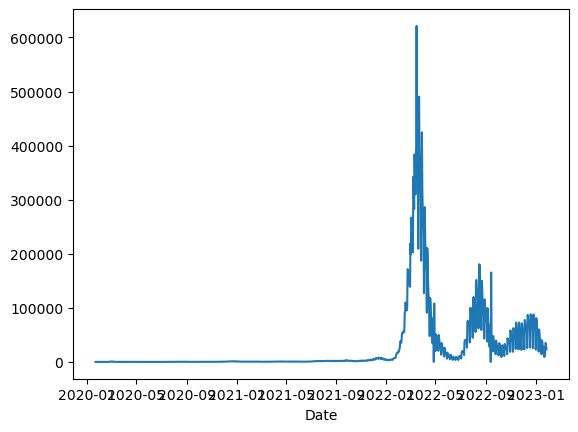

In [3]:
plt.plot(data)
plt.xlabel('Date')
plt.show()

### 계절성이 있는지 판단하는 단계

acf, pacf를 보고 계절성이 있는지 없는지만 판단하면 됨.

C:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


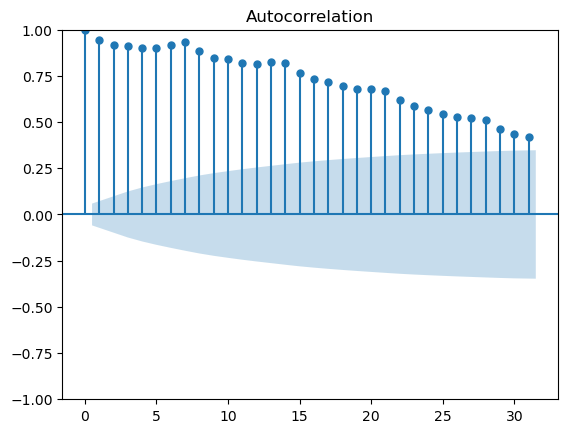

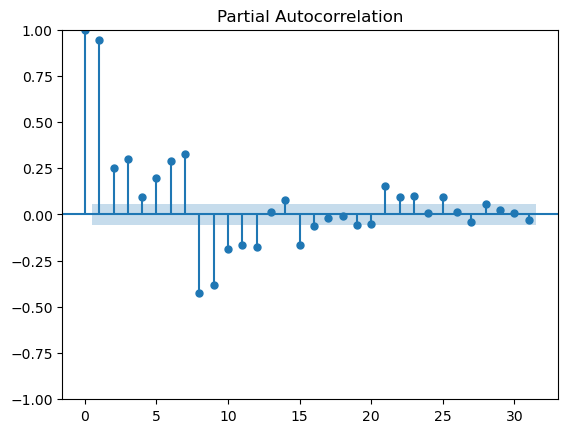

In [4]:
plot_acf(data)
plot_pacf(data)

plt.show()

### Train set, Test set 으로 분리
모델이 정확하게 추정할 수 있는지 확인하는 용도

In [5]:
train_size = int(len(data)*0.9)

train_data, test_data = train_test_split(data, train_size=train_size, shuffle=False)

print(test_data)
print(train_data)


Date
2022-10-09     8981
2022-10-10    15476
2022-10-11    30503
2022-10-12    26928
2022-10-13    23562
              ...  
2023-01-23    12262
2023-01-24    19538
2023-01-25    35096
2023-01-26    31711
2023-01-27    23367
Name: Daily, Length: 111, dtype: int64
Date
2020-01-22        1
2020-01-23        0
2020-01-24        1
2020-01-25        0
2020-01-26        1
              ...  
2022-10-04    34710
2022-10-05    28603
2022-10-06    22259
2022-10-07    19379
2022-10-08    17654
Name: Daily, Length: 991, dtype: int64


### autoARIMA 함수 사용 

위에서 계절성이 있는 거 같으면 sesonal에서 True, 없는 거 같으면 False로 변경해주면 됨. (그냥 True로 고정해두어도 작동하긴 함)

In [6]:
model = auto_arima(train_data, seasonal=True, suppress_warnings=True, error_action="ignore", stepwise=True,
                   trace=True, random_state=42)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22648.759, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22577.884, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22481.226, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22646.760, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22456.702, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22436.498, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22486.609, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=22438.172, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22427.162, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22443.764, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=22317.805, Time=0.34 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=22429.977, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=22237.507, Time=0.89 sec
 ARIMA(3,1,3)(0,0,0)[0] i

In [7]:
model.fit(train_data)


ARIMA(order=(5, 1, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### 예측 시각화

statsmodel package를 사용하기 위해 모델의 계수를 가져옴

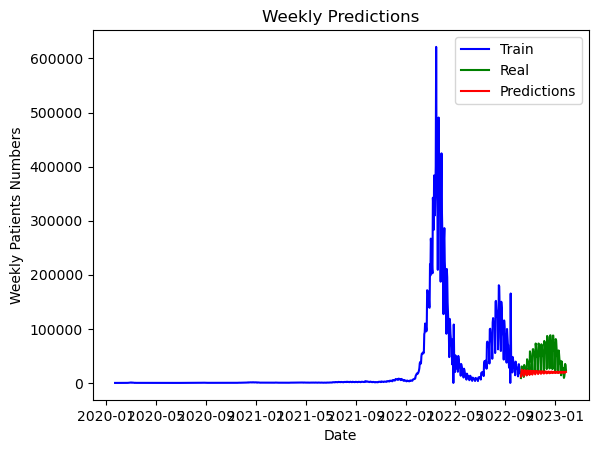

In [8]:
model_fit = model.fit(train_data)

predictions = model_fit.predict(n_periods=len(test_data))


plt.plot(train_data, label = 'Train', color = 'blue')
plt.plot(test_data, label = 'Real', color = 'green')
plt.plot(predictions, label='Predictions', color = 'red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Weekly Patients Numbers')
plt.title('Weekly Predictions')
plt.show()

### 잔차를 확인하는 작업

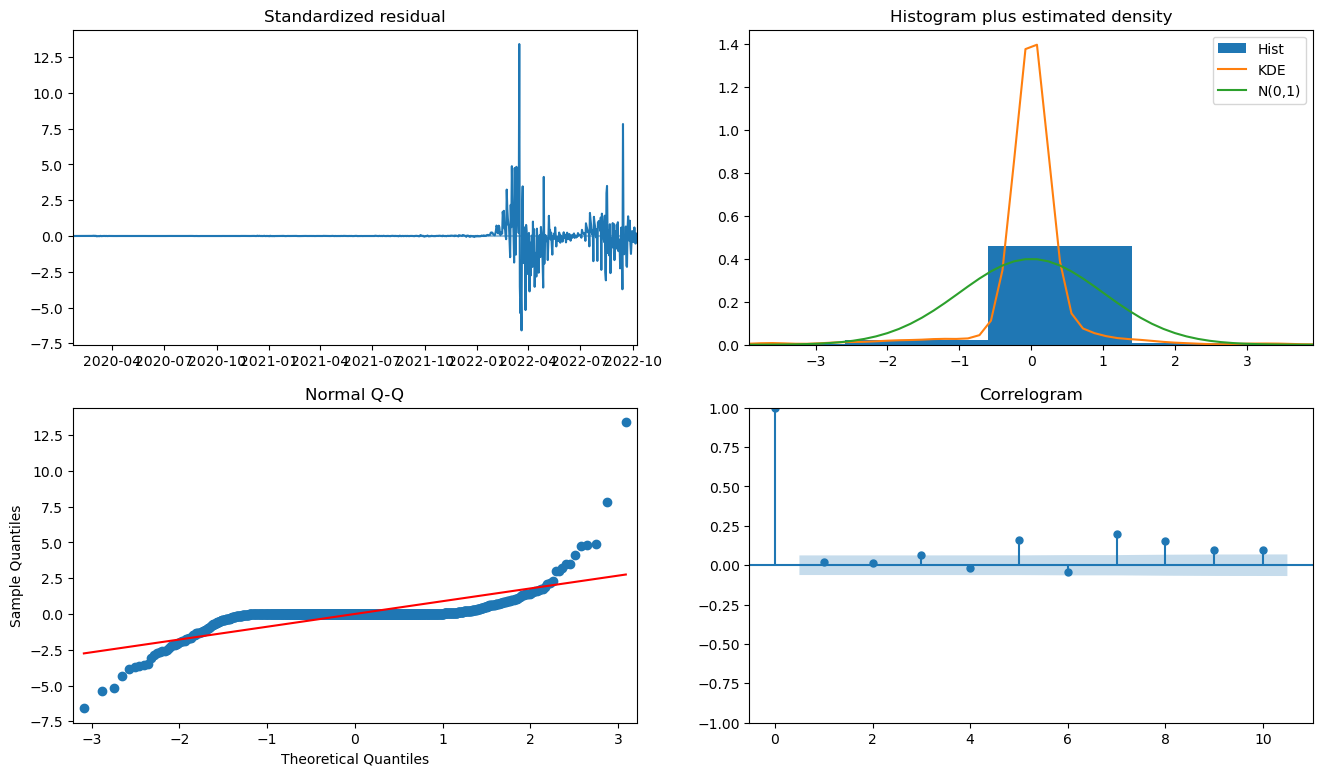

In [9]:
model_fit.plot_diagnostics(figsize = (16,9))
plt.show()

### 신뢰구간 안에 들어오는지 확인

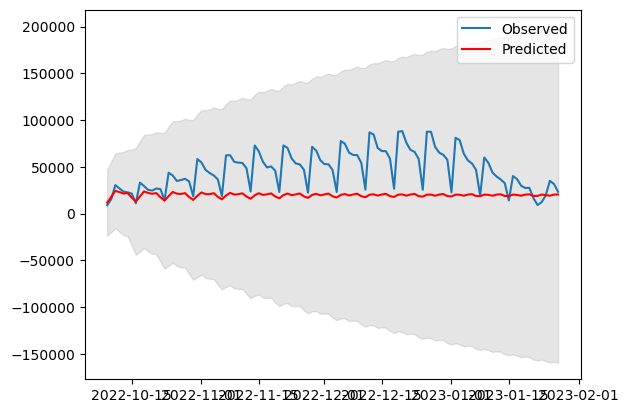

In [10]:
pred = model_fit.predict(n_periods=len(test_data), return_conf_int=True)
np.asarray(pred[1])

plt.plot(test_data, label='Observed')
plt.plot(pred[0], 'r', label='Predicted')
plt.fill_between(test_data.index, pred[1][:,0], pred[1][:,1], color='gray',alpha=0.2)
plt.legend()
plt.show()

### update 함수 사용

In [11]:
pred_data = []

for new_data in test_data:
    pred = model.predict(n_periods=1)
    pred_data.append(pred[0])
    
    model.update(new_data)
   
print(pred_data)

[11660.220471979379, 16882.65473628109, 22519.374262609395, 24673.936810756888, 23625.83170314608, 23813.669534131535, 17701.843422967933, 14964.308697650897, 21627.04868853161, 33313.84744597935, 27859.691013058746, 25262.407347644552, 25752.01004189207, 20292.16803471293, 21403.35762076018, 26086.531131107586, 35704.96900128164, 32708.139436727575, 35301.6624419143, 36978.941237845414, 30166.70933670555, 33781.566624911684, 38017.018275689625, 45727.73267669469, 41308.46101480507, 46591.01489335825, 45956.01097810682, 34122.61809293863, 40284.05798807536, 47630.92171592322, 52076.07370252843, 43428.35900118634, 49736.084392819146, 51402.52742818028, 39996.847379356856, 49956.19585691392, 61682.98099895705, 67519.90902852596, 52734.13459777262, 55610.937989097074, 51847.09834546819, 33551.23034652817, 43217.47326289939, 60330.939616797434, 67157.03143152484, 51664.868104749476, 57414.56309450984, 57623.56560712881, 37166.01677194379, 44164.23423839926, 62449.520012594076, 69254.283816

             Predictions
Date                    
2022-10-09  11660.220472
2022-10-10  16882.654736
2022-10-11  22519.374263
2022-10-12  24673.936811
2022-10-13  23625.831703
...                  ...
2023-01-23  26259.362818
2023-01-24  30981.413260
2023-01-25  16382.112447
2023-01-26  21265.864341
2023-01-27  30185.511542

[111 rows x 1 columns]


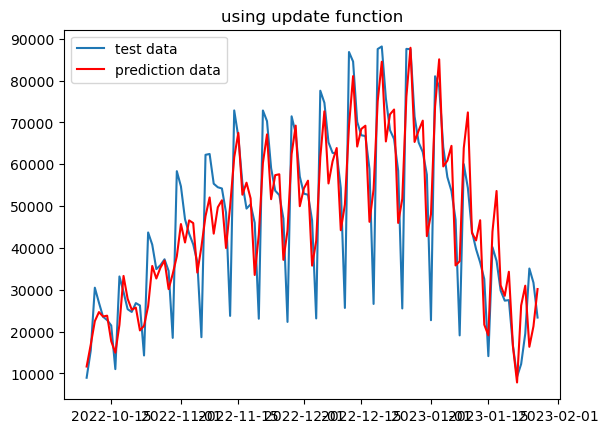

In [16]:
pred_data=pd.DataFrame(pred_data,columns=['Predictions'],index=test_data.index)

print(pred_data)

plt.plot(test_data,label='test data')
plt.plot(pred_data,label='prediction data',color='red')
plt.title("using update function")
plt.legend()
plt.show()

### 로지스틱 회귀 분석
증가할지 감소할지를 예측할 수 있는지 확인

Accuracy score: 0.6306306306306306
Confusion matrix:
 [[70  0]
 [41  0]]


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<AxesSubplot:title={'center':'Confusion Matrix of Patients Prediction'}>

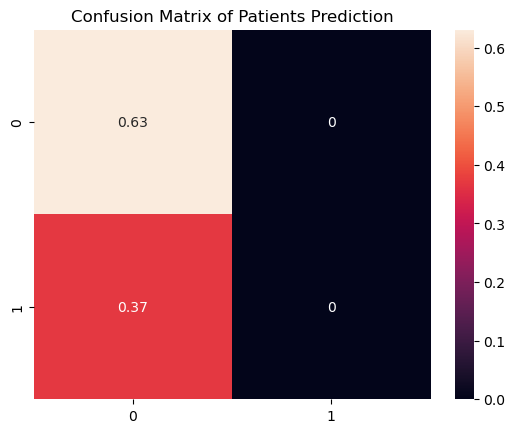

In [13]:
target = (data.diff() > 0).astype(int)

data = data.iloc[1:]
target = target.iloc[1:]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=42)

#Reshaping for 2D array
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1,1)
X_test= X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Train the Logistic Regression model on the training data
model = LogisticRegression()
model.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance using accuracy score and confusion matrix
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

plt.title("Confusion Matrix of Patients Prediction")
sns.heatmap(confusion_matrix(y_test, y_pred,normalize="pred",), annot=True)